In [24]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv("../../datasets/Invoices_Std.csv", encoding='latin-1', low_memory=False)

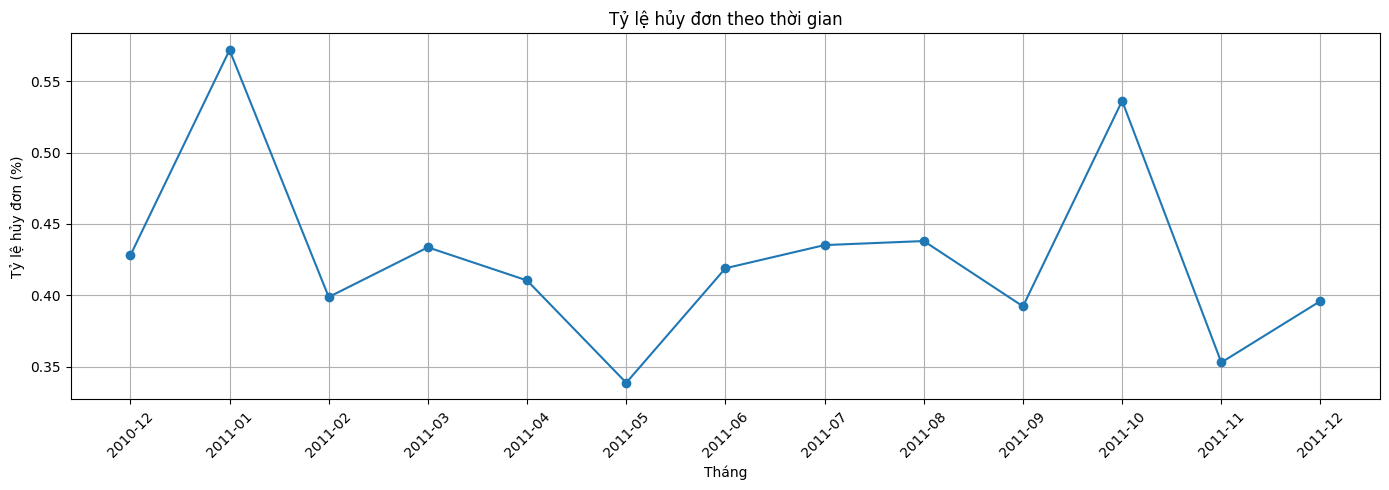

In [26]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['OrderValue'] = df['Quantity'] * df['UnitPrice']

df['CanceledValue'] = df['OrderValue'].where(df['Is_Canceled'] == 1, 0)
df['ValidValue'] = df['OrderValue'].where(df['Is_Canceled'] == 0, 0)

df['Month'] = df['InvoiceDate'].dt.to_period('M').astype(str)

cancel_rate = (
    df.groupby('Month')
    .agg(
        TotalOrders=('InvoiceNo', 'nunique'),
        CanceledOrders=('Is_Canceled', lambda x: (x == 1).sum())
    )
)
cancel_rate['CancelRate'] = cancel_rate['CanceledOrders'] / cancel_rate['TotalOrders']

plt.figure(figsize=(14, 5))
plt.plot(cancel_rate.index, cancel_rate['CancelRate'], marker='o')
plt.title("Tỷ lệ hủy đơn theo thời gian")
plt.xlabel("Tháng")
plt.ylabel("Tỷ lệ hủy đơn (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Tháng 1 và tháng 10 có tỷ lệ hủy đơn cao nhất. Cần xác định nguyên nhân do chất lượng sản phẩm, giao nhận hay các chiến dịch quảng cáo gây ảnh hưởng chính.

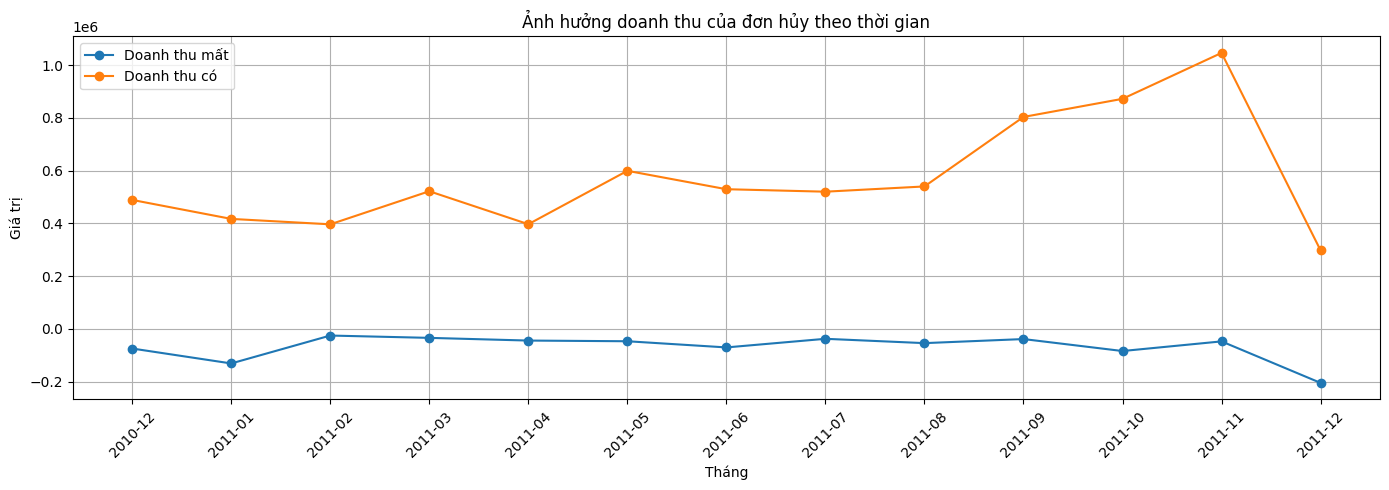

In [27]:
lost_revenue = (
    df.groupby('Month')
    .agg(
        Revenue=('ValidValue', 'sum'),
        LostRevenue=('CanceledValue', 'sum')
    )
)

plt.figure(figsize=(14, 5))
plt.plot(lost_revenue.index, lost_revenue['LostRevenue'], marker='o', label='Doanh thu mất')
plt.plot(lost_revenue.index, lost_revenue['Revenue'], marker='o', label='Doanh thu có')
plt.title("Ảnh hưởng doanh thu của đơn hủy theo thời gian")
plt.xlabel("Tháng")
plt.ylabel("Giá trị")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Tháng 1/2011 có tỷ lệ hủy cao nhất, nhưng doanh thu mất không phải là lớn nhất. Nghĩa là các đơn hàng bị hủy trong T1 có giá trị trung bình thấp.

Tháng 12/2011 có doanh thu mất lớn nhất dù tỷ lệ hủy chỉ ở mức trung bình. Nghĩa là các đơn hàng bị hủy trong T12 có giá trị trung bình rất cao.

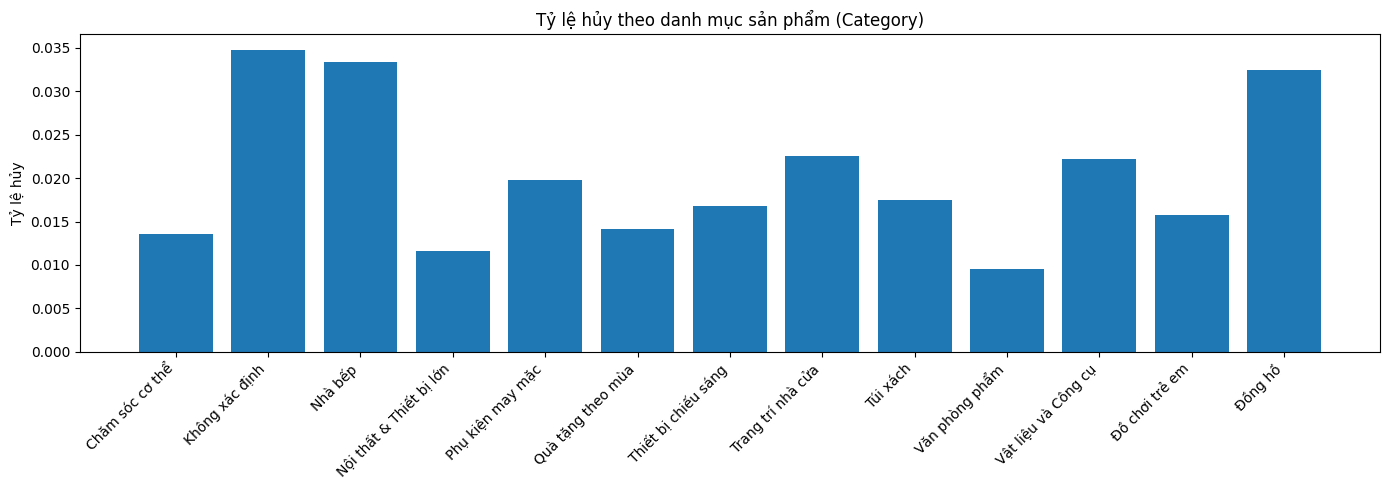

In [29]:
def custom_colored_barplot(ax, data, bins=None, color_map='jet', bar_separation=0.8):
    if bins is None:
        counts, bin_edges = np.histogram(data, bins=30)
    else:
        counts, bin_edges = np.histogram(data, bins=bins)
    
    max_count = counts.max()
    min_count = counts.min()
    
    if max_count == min_count:
        normalized_counts = np.zeros_like(counts, dtype=float)
    else:
        normalized_counts = (counts - min_count) / (max_count - min_count)
        
    colors = [mpl.colormaps[color_map](nc) for nc in normalized_counts]
    
    bar_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bar_widths = bin_edges[1:] - bin_edges[:-1]
    
    x_labels = [f'[{int(bin_edges[i])}-{int(bin_edges[i+1])}]' for i in range(len(counts))]
    
    for i in range(len(counts)):
        ax.bar(bar_centers[i], counts[i], 
               width=bar_widths[i] * bar_separation,
               edgecolor='black', color=colors[i], align='center')
        
    ax.set_xticks(bar_centers)

    if bins > 12:
        ax.set_xticklabels(x_labels, rotation=45, ha='right')
    else:
        ax.set_xticklabels(x_labels)
    
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=min_count, vmax=max_count))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Tần suất')

    return ax

CATEGORY_RULES = {
    "Trang trí nhà cửa": [
        r"t-light", r"lantern", r"candle", r"holder", r"heart", r"ornament",
        r"frame", r"cabinet", r"drawer", r"doormat", r"hanging", r"coat hanger",
        r"wood", r"sign", r"wall", r"storage tin", r"mirror", r"wreath",
        r"box", r"rack", r"pot", r"vase", r"bird", r"star", r"skull", r"hook",
        r"cushion", r"throw", r"felt", r"metal", r"ceramic", r"porcelain",
        r"shabby", r"chic", r"picture", r"shelves", r"display", r"garden",
        r"planter", r"statue", r"bamboo", r"tissue box", r"slipper", r"rug"
    ],
    "Nhà bếp": [
        r"mug", r"plate", r"cutlery", r"teaspoon", r"cake", r"tea towel",
        r"jam", r"recipe", r"snack box", r"lunch box", r"glass", r"cup",
        r"baking", r"coaster", r"bottle opener", r"apron", r"chopping board",
        r"jug", r"tray", r"kitchen", r"dish", r"salt and pepper", r"fork",
        r"knife", r"spoon", r"oil", r"vinegar", r"utensil", r"strainer",
        r"kettle", r"coffee"
    ],
    "Đồ chơi trẻ em": [
        r"playhouse", r"princess", r"doll", r"jigsaw", r"alphabet block",
        r"spaceboy", r"charlie", r"dinosaur", r"toy", r"game", r"puzzle",
        r"robot", r"tractor", r"plane", r"stickers", r"baby", r"kids",
        r"child", r"teddy", r"animal", r"miniature", r"colouring", r"clown",
        r"mermaid", r"wooden box"
    ],
    "Túi xách": [
        r"jumbo bag", r"shopper", r"storage bag", r"bag", r"basket", r"tote",
        r"pouch", r"sack", r"purse", r"wallet", r"suitcase", r"travel",
        r"holdall", r"kit bag", r"vanity case", r"luggage"
    ],
    "Quà tặng theo mùa": [
        r"christmas", r"gift", r"fairy", r"vintage", r"retro", r"bunny",
        r"easter", r"party", r"bunting", r"ribbon", r"birthday", r"celebration",
        r"new year", r"halloween", r"valentine", r"snowman", r"reindeer",
        r"santa", r"crackers"
    ],
    "Chăm sóc cơ thể": [
        r"hot water bottle", r"hand warmer", r"mug cosy", r"soap", r"bath",
        r"cosmetic", r"lotion", r"perfume", r"shampoo", r"cream", r"wash bag",
        r"sponge", r"towel", r"brush", r"manicure", r"face mask"
    ],
    "Văn phòng phẩm": [
        r"paper", r"card", r"paint set", r"sticker", r"clip", r"pen", r"pencil",
        r"notebook", r"diary", r"book", r"memo", r"postcard", r"journal",
        r"folder", r"file", r"stapler", r"eraser", r"rubber", r"ruler"
    ],
    "Thiết bị chiếu sáng": [
        r"night light", r"led", r"lamp", r"string lights", r"bulb", r"fairy lights"
    ],
    "Đồng hồ": [
        r"alarm clock", r"clock", r"watch", r"time"
    ],
    "Phụ kiện may mặc": [
        r"scarf", r"socks", r"cap", r"glove", r"jewel", r"ring", r"necklace",
        r"bracelet", r"hat", r"belt", r"tights", r"tie", r"brooch", r"pin",
        r"shoes", r"boot", r"sandal"
    ],
    "Vật liệu và Công cụ": [
        r"wire", r"tool", r"tape", r"roll", r"metal", r"glitter", r"glue",
        r"sewing", r"paint", r"kit"
    ],
    "Nội thất & Thiết bị lớn": [
        r"chair", r"table", r"bench", r"mattress", r"storage unit", r"trolley"
    ]
}

def infer_category(description):
    if not isinstance(description, str):
        return "Không xác định"
    
    text = description.lower()

    for category, patterns in CATEGORY_RULES.items():
        for p in patterns:
            if re.search(p, text):
                return category
    return "Không xác định"

df["Category"] = df["Description"].apply(infer_category)

cancel_by_cat = (
    df.groupby('Category')
    .agg(
        Total=('InvoiceNo', 'count'),
        Canceled=('Is_Canceled', lambda x: (x == 1).sum())
    )
)
cancel_by_cat['CancelRate'] = cancel_by_cat['Canceled'] / cancel_by_cat['Total']

plt.figure(figsize=(14, 5))
plt.bar(cancel_by_cat.index, cancel_by_cat['CancelRate'])
plt.title("Tỷ lệ hủy theo danh mục sản phẩm (Category)")
plt.ylabel("Tỷ lệ hủy")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Tỷ lệ hủy đơn nhìn chung là rất thấp, chủ yếu dưới 2.5%.

Doanh nghiệp cần tập trung xử lý các vấn đề hủy đơn ở ngành hàng "Nhà bếp" và "Đồng hồ".